In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
warnings.filterwarnings("ignore")

In [2]:
def calculate_theoretical_mean(params):
    """
    Oblicza teoretyczną wartość oczekiwaną (średnią) procesu VAR(1).
    Wzór: mu = (I - A)^(-1) * C
    Gdzie A to macierz współczynników, C to wektor stałych.
    """
    # Macierz współczynników A
    # X_t = beta1*X_{t-1} + delta1*Y_{t-1}
    # Y_t = beta2*X_{t-1} + delta2*Y_{t-1}
    A = np.array([
        [params['beta1'], params['delta1']],
        [params['beta2'], params['delta2']]
    ])
    
    # Wektor stałych C (alpha)
    C = np.array([params['alpha1'], params['alpha2']])
    
    # Macierz jednostkowa
    I = np.eye(2)
    
    # Sprawdzenie warunku stacjonarności (wartości własne wewnątrz okręgu jednostkowego)
    eigenvalues = np.linalg.eigvals(A)
    if np.any(np.abs(eigenvalues) >= 1):
        # Jeśli proces jest niestacjonarny, średnia nie jest zdefiniowana stabilnie.
        # W symulacji zwracamy 0, ale ostrzegamy.
        # print("Uwaga: Parametry sugerują proces niestacjonarny!")
        return 0.0, 0.0
        
    try:
        # mu = (I - A)^-1 * C
        mu = np.linalg.inv(I - A) @ C
        return mu[0], mu[1] # mu_X, mu_Y
    except np.linalg.LinAlgError:
        return 0.0, 0.0

def generate_var_data(n_obs, params, burn_in=100):
    """
    Generuje dane VAR(1) ze startem od średniej i okresem burn-in.
    """
    alpha1, beta1, delta1 = params['alpha1'], params['beta1'], params['delta1']
    alpha2, beta2, delta2 = params['alpha2'], params['beta2'], params['delta2']
    rho_eps = params['rho_eps']
    
    # Całkowita długość do wygenerowania
    n_total = n_obs + burn_in
    
    # Tablice na dane
    X = np.zeros(n_total)
    Y = np.zeros(n_total)
    eps = np.zeros(n_total)
    
    # 1. Ustalanie punktu startowego (t=0) jako średniej teoretycznej
    mu_x, mu_y = calculate_theoretical_mean(params)
    X[0] = mu_x
    Y[0] = mu_y
    
    # Epsilon startuje od 0 (wartość oczekiwana szumu)
    eps[0] = 0 
    
    # Skalowanie szumu dla epsilon (Var(eps)=1)
    if abs(rho_eps) < 1:
        std_u = np.sqrt(1 - rho_eps**2)
    else:
        std_u = 1.0

    # Generowanie innowacji losowych
    u = np.random.normal(0, std_u, n_total)
    eta = np.random.normal(0, 1, n_total)
    
    # Pętla generująca (od t=1)
    for t in range(1, n_total):
        # Generowanie autokorelowanego błędu epsilon (AR(1))
        eps[t] = rho_eps * eps[t-1] + u[t]
        
        # Równania VAR
        X[t] = alpha1 + beta1*X[t-1] + delta1*Y[t-1] + eps[t]
        Y[t] = alpha2 + beta2*X[t-1] + delta2*Y[t-1] + eta[t]
        
    # Odrzucamy okres burn-in (zwracamy ostatnie n_obs)
    return pd.DataFrame({'X': X[burn_in:], 'Y': Y[burn_in:]}).reset_index(drop=True)

def run_granger_test_ols(df, max_lag_hac1, max_lag_hac2):
    """Przeprowadza test Walda (Grangera) z poprawkami HAC."""
    # Tworzenie opóźnień
    df['X_lag1'] = df['X'].shift(1)
    df['Y_lag1'] = df['Y'].shift(1)
    df = df.dropna()
    
    y_var = df['X']
    # Macierz zmiennych objaśniających (Stała, X_{t-1}, Y_{t-1})
    X_vars = sm.add_constant(df[['X_lag1', 'Y_lag1']])
    
    # Dopasowanie OLS
    model = sm.OLS(y_var, X_vars)
    results = model.fit()
    
    # Hipoteza: Czy współczynnik przy Y_lag1 jest zerowy?
    hypothesis = '(Y_lag1 = 0)'
    
    # Pobieranie p-value dla różnych estymatorów macierzy kowariancji
    p_std = results.f_test(hypothesis).pvalue
    
    # HAC (Newey-West)
    p_hac1 = results.get_robustcov_results(cov_type='HAC', maxlags=max_lag_hac1).f_test(hypothesis).pvalue
    p_hac2 = results.get_robustcov_results(cov_type='HAC', maxlags=max_lag_hac2).f_test(hypothesis).pvalue
    
    return float(p_std), float(p_hac1), float(p_hac2)


In [3]:
def plot_simulation_results(results_df, alpha_level):
    """
    Rysuje słupkowy wykres wyników.
    - Układ: Rzędy = Scenariusze, Kolumny = N.
    - N jest wypisane nad KAŻDYM wykresem.
    - Alfa z przecinkiem (0,05).
    - Jeden wspólny tytuł scenariusza pośrodku rzędu.
    - Osobna legenda dla każdego rzędu po prawej.
    """
    print("Generowanie wykresu wyników symulacji...")
    
    # --- PRZYGOTOWANIE DANYCH ---
    melted = results_df.melt(
        id_vars=['N', 'rho_eps', 'Scenariusz'], 
        value_vars=['Size_STD', 'Size_HAC_Short', 'Size_HAC_Long'],
        var_name='Estymator', value_name='Rejection_Rate'
    )
    
    names_map = {
        'Size_STD': 'OLS (Standard)',
        'Size_HAC_Short': 'HAC (Lag=2)',
        'Size_HAC_Long': 'HAC (Lag=N^0.25)'
    }
    melted['Estymator'] = melted['Estymator'].map(names_map)

    # Sortowanie scenariuszy
    scenarios_order = results_df['Scenariusz'].unique()
    unique_Ns = sorted(results_df['N'].unique())

    # Formatowanie alfa z przecinkiem (np. 0,05)
    alpha_str = str(alpha_level).replace('.', ',')

    # --- RYSOWANIE WYKRESU ---
    g = sns.catplot(
        data=melted, 
        x='rho_eps', y='Rejection_Rate', hue='Estymator',
        col='N', row='Scenariusz', kind='bar',
        row_order=scenarios_order,
        height=3.0, aspect=1.4, palette='viridis',
        edgecolor='black', linewidth=0.5,
        sharex=False, sharey=False, 
        legend=False, margin_titles=False
    )
    
    g.set_titles("") # Usuwamy domyślne tytuły

    axes = g.axes
    num_rows, num_cols = axes.shape

    # --- ELEMENTY LEGENDY ---
    colors = sns.color_palette('viridis', 3)
    estimator_handles = [
        Patch(facecolor=colors[0], edgecolor='black', label='OLS (Standard)'),
        Patch(facecolor=colors[1], edgecolor='black', label='HAC (Lag=2)'),
        Patch(facecolor=colors[2], edgecolor='black', label='HAC (Lag=N^0,25)')
    ]
    # Linia alfa z przecinkiem
    alpha_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=2, label=f'α = {alpha_str}')

    # --- ITERACJA PO PANELACH ---
    for i, ax in enumerate(axes.flat):
        row_idx = i // num_cols
        col_idx = i % num_cols
        
        # 1. TYTUŁ N NAD KAŻDYM WYKRESEM
        current_N = unique_Ns[col_idx]
        ax.set_title(f"N = {current_N}", fontsize=10, color='#333333', pad=6)

        # 2. Linia alpha i skalowanie
        ax.axhline(y=alpha_level, color='red', linestyle='--', linewidth=2, zorder=0)
        
        bars_heights = [bar.get_height() for container in ax.containers for bar in container]
        if bars_heights:
            y_max_local = max(bars_heights)
            ax.set_ylim(0, max(y_max_local * 1.2, alpha_level * 3.0))
        
        # 3. Osie
        ax.tick_params(axis='x', rotation=0, labelsize=9)
        ax.set_xlabel(r'$\rho$ (autokorelacja)', fontsize=10)

        
        ax.set_ylabel('Empiryczny Rozmiar', fontsize=9)
        ax.grid(axis='y', alpha=0.3, linestyle=':', linewidth=0.8)

        # 4. TYTUŁ SCENARIUSZA (Centralny nad parą)
        if col_idx == 0:
            scenario_name = scenarios_order[row_idx]
            ax.annotate(scenario_name,
                        xy=(1.15, 1.30), xycoords='axes fraction',
                        ha='center', va='bottom', 
                        fontsize=11, fontweight='bold', 
                        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.9))

    # --- LEGENDY (Dla każdego rzędu) ---
    for row in range(num_rows):
        ax_last = axes[row, -1]
        
        # Legenda 1: Linia Alpha
        legend_alpha = ax_last.legend(
            handles=[alpha_handle],
            loc='upper left',
            bbox_to_anchor=(1.02, 1.0),
            frameon=False, fontsize=9
        )
        ax_last.add_artist(legend_alpha)
        
        # Legenda 2: Estymatory
        ax_last.legend(
            handles=estimator_handles,
            loc='upper left',
            bbox_to_anchor=(1.02, 0.8),
            title="Estymator",
            frameon=True, fontsize=9
        )

    g.fig.suptitle(
        "Test SIZE Grangera: Analiza symulacyjna (H0 prawdziwe: δ₁=0)", 
        y=1.01, fontsize=16, fontweight='bold'
    )
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, right=0.82, hspace=0.7, wspace=0.3)
    plt.show()


def plot_time_series_comparison(fixed_params):
    """Rysuje przykładowe przebiegi szeregów dla różnych scenariuszy."""
    print("Generowanie wykresów przebiegu szeregów...")
    
    # Scenariusz 1: Brak autokorelacji błędów
    params_low = fixed_params.copy()
    params_low.update({'beta1': 0.5, 'delta1': 0.0, 'beta2': 0.0, 'delta2': 0.5, 'rho_eps': 0.0})
    
    # Scenariusz 2: Silna autokorelacja błędów
    params_high = fixed_params.copy()
    params_high.update({'beta1': 0.5, 'delta1': 0.0, 'beta2': 0.0,   'delta2': 0.5, 'rho_eps': 0.9})
    
    # Scenariusz 3: Silna inercja + silna autokorelacja
    params_extreme = fixed_params.copy()
    params_extreme.update({'beta1': 0.95, 'delta1': 0.0, 'beta2': 0.0, 'delta2': 0.95, 'rho_eps': 0.9})
    
    # Scenariusz 4: Ujemna autokorelacja (oscylacje błędów)
    params_negative = fixed_params.copy()
    params_negative.update({'beta1': 0.5, 'delta1': 0.0, 'beta2': 0.0, 'delta2': 0.5, 'rho_eps': -0.9})
    
    df_low = generate_var_data(200, params_low)
    df_high = generate_var_data(200, params_high)
    df_extreme = generate_var_data(200, params_extreme)
    df_negative = generate_var_data(200, params_negative)
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
    
    # Wykres 1: Brak autokorelacji błędów
    axes[0].plot(df_low['X'], label='X (Proces)', color='blue', alpha=0.7, linewidth=1.5)
    axes[0].plot(df_low['Y'], label='Y (Predyktor)', color='orange', alpha=0.7, linestyle='--', linewidth=1.5)
    axes[0].set_title(r'Scenariusz 1: Brak autokorelacji błędu ($\rho=0,0$, $\beta_1=0,5$)', 
                      fontsize=12, fontweight='bold')
    axes[0].legend(loc='upper right', fontsize=10)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylabel('Wartość', fontsize=10)
    
    # Wykres 2: Silna dodatnia autokorelacja błędów
    axes[1].plot(df_high['X'], label='X (Proces)', color='darkblue', alpha=0.8, linewidth=1.5)
    axes[1].plot(df_high['Y'], label='Y (Predyktor)', color='darkorange', alpha=0.7, linestyle='--', linewidth=1.5)
    axes[1].set_title(r'Scenariusz 2: Silna dodatnia autokorelacja błędu ($\rho=0,9$, $\beta_1=0,5$)', 
                      fontsize=12, fontweight='bold')
    axes[1].legend(loc='upper right', fontsize=10)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylabel('Wartość', fontsize=10)
    
    # Wykres 3: Silna inercja + silna autokorelacja (quasi-niestacjonarny)
    axes[2].plot(df_extreme['X'], label='X (Proces)', color='darkgreen', alpha=0.8, linewidth=1.5)
    axes[2].plot(df_extreme['Y'], label='Y (Predyktor)', color='red', alpha=0.7, linestyle='--', linewidth=1.5)
    axes[2].set_title(r'Scenariusz 3: Quasi-niestacjonarny ($\rho=0,9$, $\beta_1=0,95$)', 
                      fontsize=12, fontweight='bold')
    axes[2].legend(loc='upper right', fontsize=10)
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylabel('Wartość', fontsize=10)
    
    # Wykres 4: Ujemna autokorelacja (oscylacje)
    axes[3].plot(df_negative['X'], label='X (Proces)', color='purple', alpha=0.8, linewidth=1.5)
    axes[3].plot(df_negative['Y'], label='Y (Predyktor)', color='brown', alpha=0.7, linestyle='--', linewidth=1.5)
    axes[3].set_title(r'Scenariusz 4: Ujemna autokorelacja błędu ($\rho=-0,9$, $\beta_1=0,5$)', 
                      fontsize=12, fontweight='bold')
    axes[3].legend(loc='upper right', fontsize=10)
    axes[3].grid(True, alpha=0.3)
    axes[3].set_ylabel('Wartość', fontsize=10)
    axes[3].set_xlabel('Czas (t)', fontsize=11)
    
    plt.suptitle('Porównanie przebiegów szeregów czasowych VAR(1)\n(Brak przyczynowości Grangera: δ₁=0)', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

In [4]:
def simulation_study():
    N_SIMULATIONS = 1000  
    SAMPLE_SIZES = [100, 1000]
    ALPHA_LEVEL = 0.05
    
    Scenariuszs = [
        {
            'name': '1. β=0,3, δ₂=0,3',
            'beta1': 0.3, 'delta1': 0.0,
            'beta2': 0.0, 'delta2': 0.3
        },
        {
            'name': '2. β=0,6, δ₂=0,6',
            'beta1': 0.6, 'delta1': 0.0,
            'beta2': 0.0, 'delta2': 0.6
        },
        {
            'name': '3. β=0,9, δ₂=0,9',
            'beta1': 0.9, 'delta1': 0.0,
            'beta2': 0.0, 'delta2': 0.9
        },
        {
            'name': '4. β=0,98, δ₂=0,98',
            'beta1': 0.98, 'delta1': 0.0,
            'beta2': 0.0,  'delta2': 0.98
        },
        {
            'name': '5. β=-0,5, δ₂=-0,5',
            'beta1': -0.5, 'delta1': 0.0,
            'beta2': 0.0,  'delta2': -0.5
        },
        {
            'name': '6. Asymetria: X wolny, Y szybki',
            'beta1': 0.9, 'delta1': 0.0,
            'beta2': 0.0, 'delta2': 0.2
        },
        {
            'name': '7. Asymetria: X szybki, Y wolny',
            'beta1': 0.2, 'delta1': 0.0,
            'beta2': 0.0, 'delta2': 0.9
        },
        {
            'name': '8. β=-0,8, δ₂=-0,8',
            'beta1': -0.8, 'delta1': 0.0,
            'beta2': 0.0,  'delta2': -0.8
        },
        {
            'name': '9. β=-0,2, δ₂=0,2',
            'beta1': -0.2, 'delta1': 0.0,
            'beta2': 0.0,  'delta2': 0.2
        },
        {
            'name': '10. β=0,2, δ₂=-0,2',
            'beta1':  0.2, 'delta1': 0.0,
            'beta2': 0.0,  'delta2': -0.2
        }
    ]
    
    rho_values = [-0.9, -0.5, 0.0, 0.5, 0.9]
    
    base_params = {'alpha1': 0.5, 'alpha2': 0.5}
    
    plot_time_series_comparison(base_params)
    
    results_store = []
    print(f"Rozpoczynanie symulacji ({N_SIMULATIONS} powtórzeń)...")
    
    for N in SAMPLE_SIZES:
        lag_short = 2
        lag_long = int(N**(0.25))
        
        for sc in Scenariuszs:
            for rho in rho_values:
                params = base_params.copy()
                params.update(sc)
                params['rho_eps'] = rho
                
                rej_std, rej_hac1, rej_hac2 = 0, 0, 0
                
                valid_sims = 0
                for _ in range(N_SIMULATIONS):
                    df = generate_var_data(N, params)
                    
                    # Ignorujemy wybuchy numeryczne
                    if df.abs().max().max() > 1e10: 
                        continue
                        
                    p_std, p_hac1, p_hac2 = run_granger_test_ols(df, lag_short, lag_long)
                    
                    if p_std < ALPHA_LEVEL: rej_std += 1
                    if p_hac1 < ALPHA_LEVEL: rej_hac1 += 1
                    if p_hac2 < ALPHA_LEVEL: rej_hac2 += 1
                    valid_sims += 1
                
                if valid_sims > 0:
                    results_store.append({
                        'N': N, 'Scenariusz': sc['name'], 'rho_eps': rho,
                        'Size_STD': rej_std / valid_sims,
                        'Size_HAC_Short': rej_hac1 / valid_sims,
                        'Size_HAC_Long': rej_hac2 / valid_sims,
                        'Valid_Sims': valid_sims
                    })

    results_df = pd.DataFrame(results_store)
    
    # ANALIZA WYNIKÓW
    print("\n" + "="*80)
    print("CZĘŚĆ 3: ANALIZA WYNIKÓW SYMULACJI")
    print("="*80)
    
    print("\n--- Wyniki dla silnej dodatniej autokorelacji (rho=0.9) ---")
    mask = results_df['rho_eps'] == 0.9
    print(results_df[mask][['N', 'Scenariusz', 'Size_STD', 'Size_HAC_Short', 'Size_HAC_Long']].to_string(index=False))
    
    print("\n--- Wyniki dla ujemnej autokorelacji (rho=-0.9) ---")
    mask2 = results_df['rho_eps'] == -0.9
    print(results_df[mask2][['N', 'Scenariusz', 'Size_STD', 'Size_HAC_Short', 'Size_HAC_Long']].to_string(index=False))
    
    print("\n--- Top 5 scenariuszy z największym over-rejection (OLS Standard) ---")
    worst_cases = results_df.nlargest(5, 'Size_STD')[['N', 'Scenariusz', 'rho_eps', 'Size_STD',  'Size_HAC_Short', 'Size_HAC_Long']]
    print(worst_cases.to_string(index=False))
    
    print("\n")
    print("TABELE ZBIORCZE: Średnia (Mean) vs Najgorszy Przypadek (Max)")

    for N in SAMPLE_SIZES:
        print(f"\n>>> Wyniki dla N = {N} <<<")
        
        # Grupujemy po rho_eps i liczymy średnią oraz maksimum dla każdego estymatora
        summary = results_df[results_df['N'] == N].groupby('rho_eps')[
            ['Size_STD', 'Size_HAC_Short', 'Size_HAC_Long']
        ].agg(['mean', 'max'])
        
        # Formatowanie tabeli dla czytelności
        print(summary.to_string())
    plot_simulation_results(results_df, ALPHA_LEVEL)
    
    return results_df

Generowanie wykresów przebiegu szeregów...


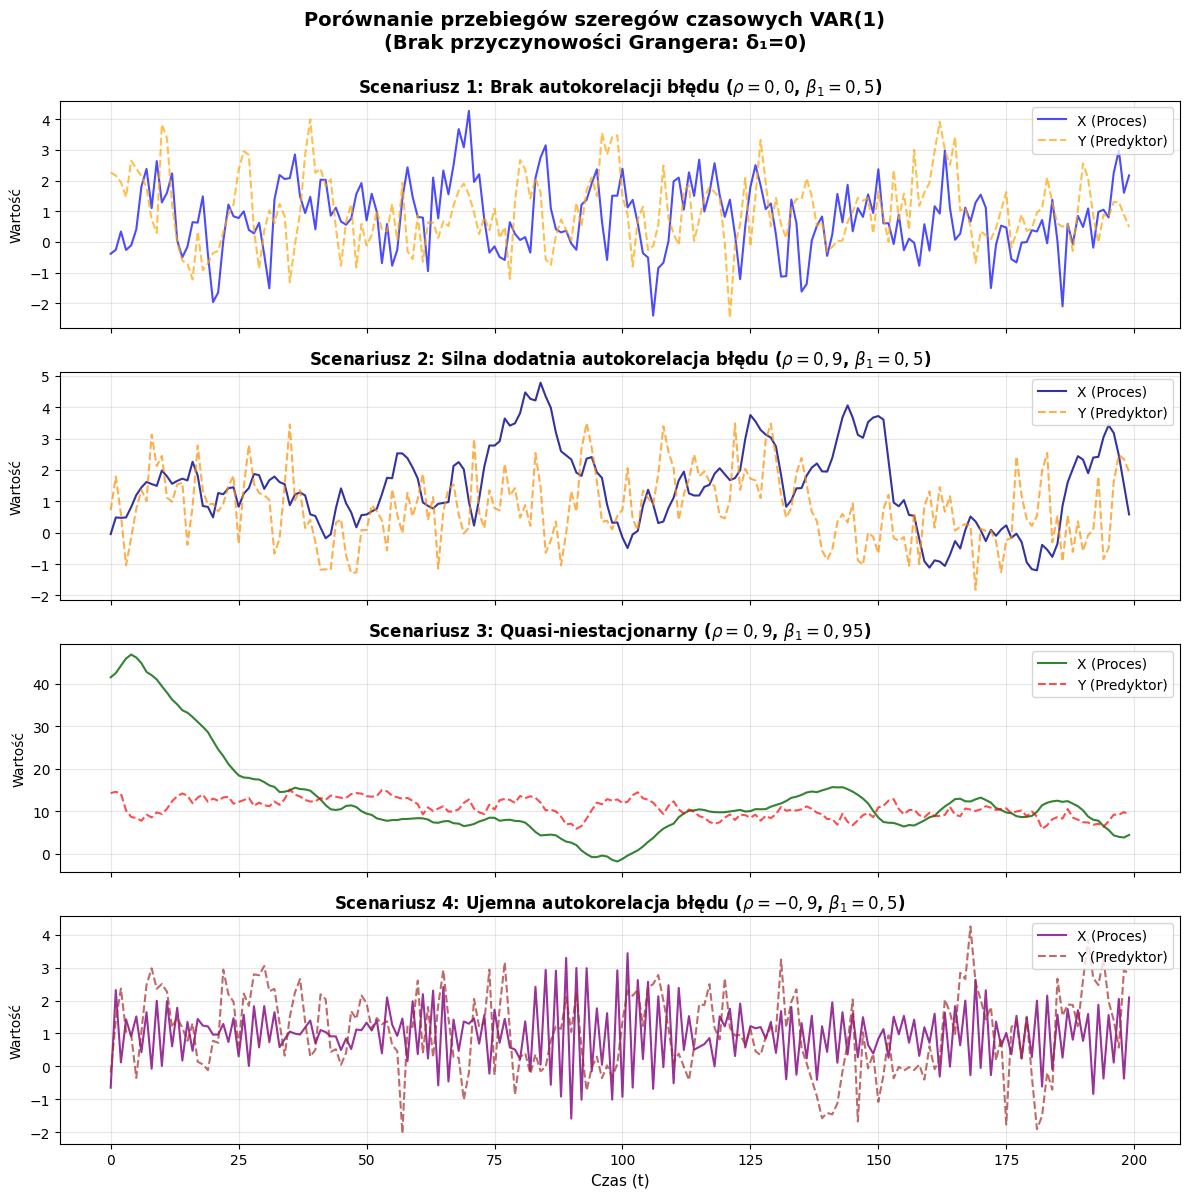

Rozpoczynanie symulacji (1000 powtórzeń)...

CZĘŚĆ 3: ANALIZA WYNIKÓW SYMULACJI

--- Wyniki dla silnej dodatniej autokorelacji (rho=0.9) ---
   N                      Scenariusz  Size_STD  Size_HAC_Short  Size_HAC_Long
 100                1. β=0,3, δ₂=0,3     0.070           0.079          0.080
 100                2. β=0,6, δ₂=0,6     0.154           0.114          0.113
 100                3. β=0,9, δ₂=0,9     0.417           0.303          0.275
 100              4. β=0,98, δ₂=0,98     0.582           0.455          0.419
 100              5. β=-0,5, δ₂=-0,5     0.099           0.095          0.092
 100 6. Asymetria: X wolny, Y szybki     0.090           0.085          0.084
 100 7. Asymetria: X szybki, Y wolny     0.099           0.109          0.110
 100              8. β=-0,8, δ₂=-0,8     0.252           0.208          0.194
 100               9. β=-0,2, δ₂=0,2     0.046           0.054          0.062
 100              10. β=0,2, δ₂=-0,2     0.046           0.064          0.068
1

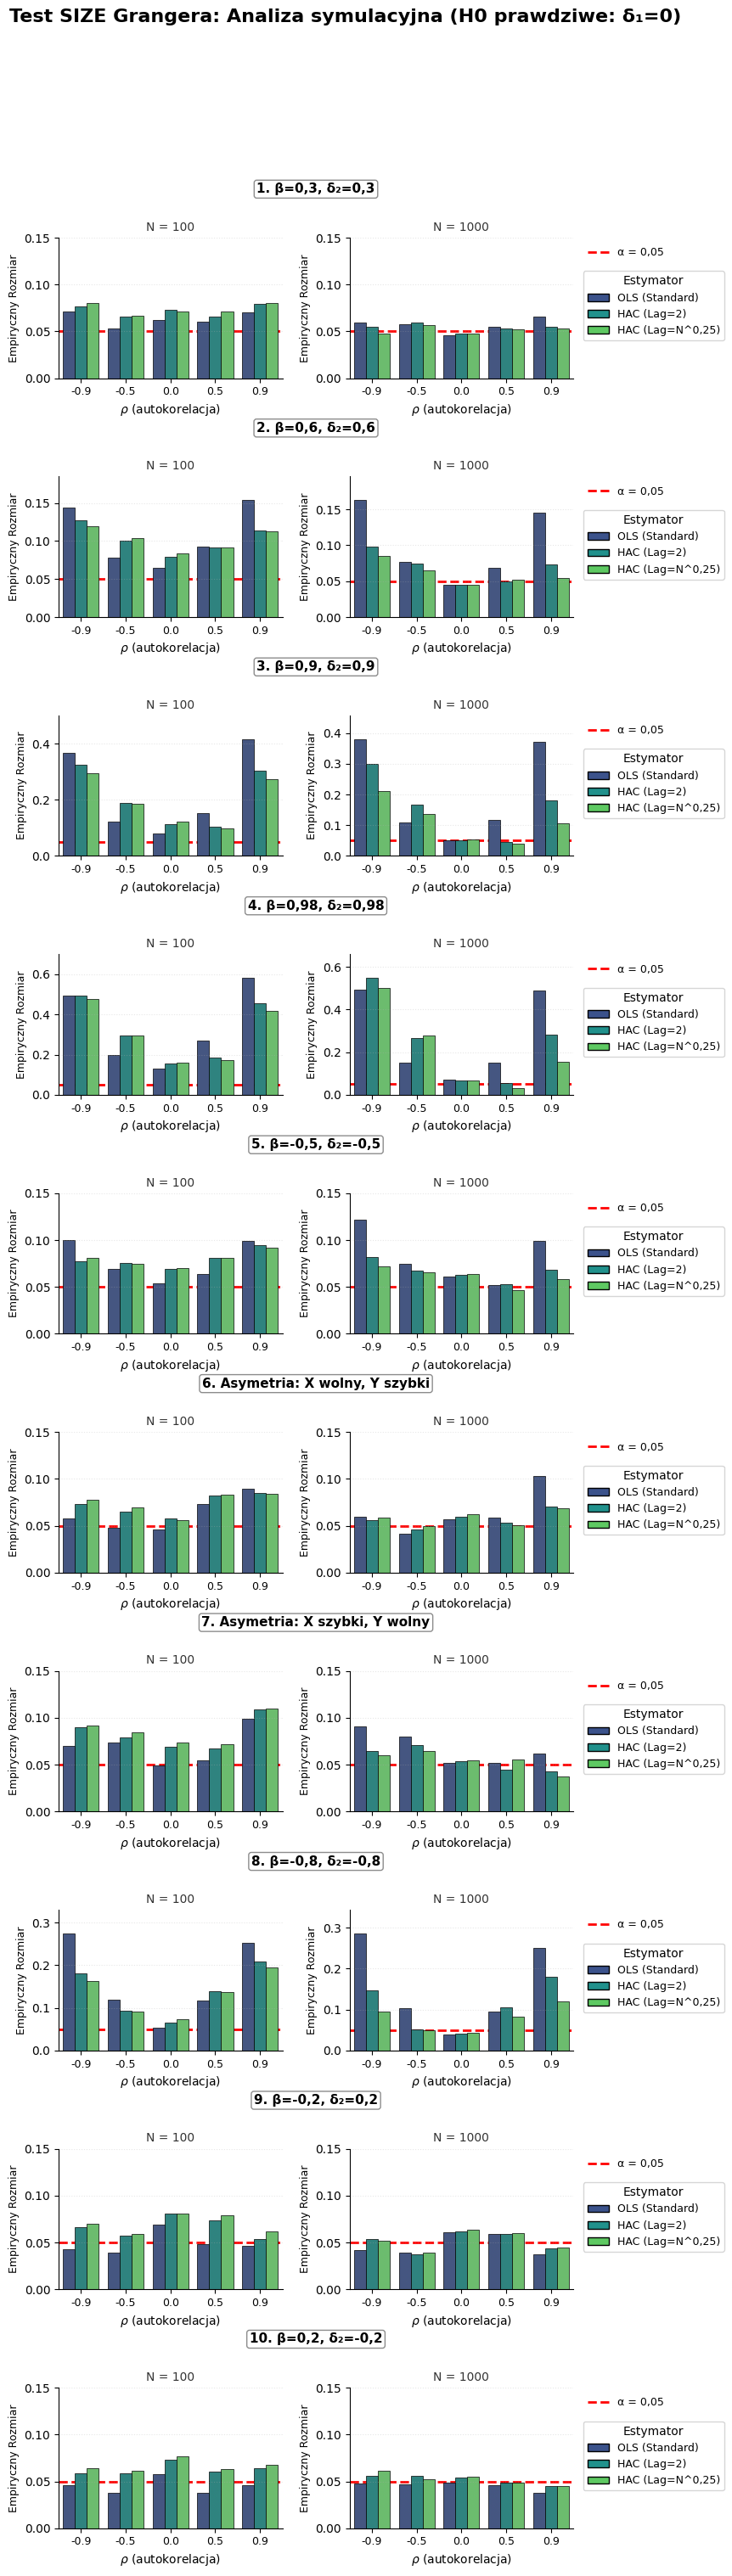

In [5]:
np.random.seed(12345) 
results_df = simulation_study()

In [6]:
results_df.to_csv("simulation_results.csv", index=False)